# Autoencoders for anomaly detection in Oxford Nanopore Technology direct RNA-Sequencing: identification of modified nucleotides.

**Author:** Adriano Fonzino, Ph.D.

## 1.0. Introduction
Recently, many efforts have been sustained in order improve our ability to identify and map RNA modifications. These have been mainly focused on the use of next generation sequencing techniques. These platforms are, however, usually blind to nucleotides modification since they require a cDNA library preparation steps that masks base modifications. Furthermore, these are only indirect detection methods, without a univoque starndard and generic approach to retrieve the position and presence of RNA modifications at single base resolutions. Some protocols expect the use of specific antibotidies to recognize modifications or the use of chemical pretreatments (also in-vivo) with substances able to react specifically with modified bases. The incredible amount of RNA modifications (more than 150 at least) is not suitable to be harnessed easely only with this approaches since these are bound to the availability of both specific antibodies and chemical reagents. <br>

In this context Oxford Nanopore Technology (ONT) could play a pivotal role as game changer in the field of direct RNA sequencing and RNA/DNA modification detection. ONT is a company founded in 2005 as a spin-out from the University of Oxford. They produced a set of technologies used for single-molecule, long-read sequencing of DNA and RNA sequence. ONT sequencing is based on the use of a membrane with an array of nanopores, where the polynucleotide chain pass through generating a ionic current change since the voltage is "clamped" across the two side of the flowcell.

ONT is labelled, together with Pacific Biosciences (PacBio) instruments, as third-generation sequencing technologies and have been recently purposed as new tool for the dection of RNA modifications in native RNA sequences. It allowed, also thanks new protocols, the sequencing of direct-RNA single-molecules without the need of the intermediate cDNA library construction step. This ONT feature is very important and promising since it gives the possibility to preserve the nucleotide modifications as well.
In a nutshell, when modified nucleotides are present into the sequenced molecule, they cause a disruption of the ionic current across the pore that can be potentially identified by comparing raw current signals, known as "squiggle". Today, the main tool that tries to perform this inference is **Tombo**, a deep learning based algoritmh that requires a challeging step of re-squiggling and alignment of the current intensities and that it is "only" focused on m6A and m5C modifications at the moment.
Recently, in an article published on Nature Communications in the 2019 by Liu et al., researchers trained a Support Vector Machine (SVM) classifier that is able to predict modified m6A nucleotides into ONT native RNA-sequencing experiments basing on the "errors" that basecallers usually make when encounter base modifications. Thus, they understood and demonstrated that, basecallers "errors" can be interpretated as putative presence of a RNA modifications. They used an *in-vitro* transcribed 10kb-long artificial sequence to evaluate this aspect. The sequence, called here "curlcake" (from the software's name, used to produce it), contains all the possible combinations among the 4 nucleotides (A, C, G, U/T) in a kmer of length 5. They created two samples, one synthetized in presence of m6A-mofified nucleotides, and the other in absence of these as control, used to train the SVM model. Researchers called the model **EpiNano**. Results where confirmed by experiments using enginnered knock-out Yeasts not able to catalize m6A related reactions. The algoritmh were able to predict m6A modifications with a good degree of accuracy (about 90%). One of the limitations of EpiNano is the need of both control and modified samples to makes predictions.

This model can be obviously improved and put the basis of the experiment of this notebook. If both Tombo and EpiNano are able to predict RNA modifications basing on raw signals and basecallers errors, respectively, it means that probably, informations about the precence of modified nucleotides are embedded inside the raw signal of the ONT instrumentation. Tombo and EpiNano tries to make inferences with a supervised learning strategy using a binary classifiers (Deep Neural Network, DNN, and SVM) focusing on single type of modification at once. Here, I want to purpose a more general approach with respect the binary/multiclass classification strategy, that relies on either raw signals and basecaller errors, the latter intended in this case as anomalities of the currents, to predict someway which is the portion of the signal that is suspected to be related to bases modification. Indeed, a very interesting and powerful keypoint of the EpiNano strategy, is the choise to use synthetic constructs, with and without modifications, as training datasets. Thus in general, it could be that, everything outside the "normality" of unmodified 5mers produced signals, can potentially be correlated to modified nucleotides, in general. This is a problem that classically fall into the **Anomaly Detection** Field in signal interpretation.

Nowadays, the state of the art algoritmhs used for this purpose, are the **Autoencoders**, a group of generative unsupervised deep learning algoritmhs used for the reconstruction of high-dimensional input data. Summarizing, Autoencoders are DNN with narrow bottleneck layer at their center which contains the latent representation of the input data. The first part of the DNN that procude, starting from inputs, this latent representation is called **Encoder**, while the second part of the DNN is called **Decoder** because its aim is to reconstruct with the input data from the latent state minimizing the error between inputs and reconstructed output. 

<center> <img src='LSTM-Autoencoder-for-Anomaly-Detection.png' width="600" height="400"> </center>
<center> <i> AutoEncoder Structure. </i> </center> <br>

Autoencoders are used for several application, for instance Dimensionality Reduction, Reccomandation Engines, Images Denoising, Recongnition and Generation and also for Anomaly Detection. It there exist several types of autoencoders implementations with one common geneal architecture: an Encoder, a latent representation in the middel (the bottleneck) and the decoder. It is possible to use either a classic shallow feed-forward DNN, a Recurrent Neural Network (RNN), a Long Short Term-Memory (LTSM) DNN, etc. <br>
<br>

<center> <img src='RNN_image.jpg' width="500" height="131"> </center>
<center> <i> Recurrent Neural Network architecture. </i> </center> <br>

<br>
<br>
<br>
<br>

<center> <img src='LSTM_image.jpg' width="600" height="225"> </center>
<center> <i> Long-Short-Term-Memory Recurrent Neural Network architecture. </i> </center> <br>

The aim of this work is, in the end, to build an efficient Autoencoder trained on un-modified RNA raw signals data from ONT experiments able to detect anomalities in the modified (m6A) RNA raw signals using as dataset the EpiNano "curlcake" artifical constructs. See the "curlcake_dataset_exploration.ipynb" notebook for more information about the characteristics of the dataset.

<br>
<br>

<center> <img src='LSTM_AE_time_series.jpg' width="700" height="350"> </center>
<center> <i> LSTM-AE on timeserie data. </i> </center> <br>


In [1]:
# importing basic modules
import os
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from tqdm import tqdm
from ont_fast5_api.fast5_interface import get_fast5_file
from ont_custom_functions import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
import tensorflow as tf
import keras
from keras.layers import Input, Dropout, Dense, Bidirectional, LSTM, TimeDistributed, RepeatVector
from keras.models import Sequential
from keras import regularizers
from keras.callbacks import ModelCheckpoint

In [2]:
# set a random seed for reproducibility reason.
np.random.seed(1234)
tf.random.set_seed(1234)

## 2.0. Retrieve data

For sake of test, the first part of the computation will be performed on a subset of the data that fit in memory in order to evaluate the general behaviour of the network.
The autoencoders will be trained on a subset of the raw signal generated by the unmodified reads. A small part of this subset will be used to evaluate the performance on the unmodified data. Here the autoencoder shouldn't be able to find anomalities. After the test of the model on the unmodified reads, it will be challenged with a subset of raw signals of the m6A-related reads where the models should be able to detect anomalities. Then, the anomalities detected will be evaluated and analyzed to understand the abilities of the DNN to find, in a unsupervised manner, the modified nucleotides as anomalities. Data are stored as fast5 files (a dialect of the HDF5 file format) on the disk and have been previously mapped into a pandas DataFrame into the "curlcake_dataset_exploration.ipynb" of this project and saved as a .csv file.

In [3]:
# load mapped daset from csv created into "curlcake_dataset_exploration.ipynb"
df = pd.read_csv("df_curlcake_reads.csv", index_col=0)
df.head()

,data,FlowcellID,DeviceID,read_type,SampleName,read,channel,m6A,path,fastq,read_id,read_length,read_max,read_min,read_mean,read_median,read_std
0,20180726,FAH84534,GA20000,mux_scan,RNAAB090763,10,472,Yes,C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...,Yes,5ba8d6a5-e25b-4688-9b55-1372bcd2cbd2,29745,159.934707,-60.048745,92.866259,88.754975,17.639826
1,20180726,FAH84534,GA20000,mux_scan,RNAAB090763,10,76,Yes,C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...,No,4810658b-f383-49e4-9044-050d963aff73,7371,158.763024,56.973078,93.447985,88.462054,19.664399
2,20180726,FAH84534,GA20000,mux_scan,RNAAB090763,11,329,Yes,C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...,Yes,9cfa4d57-5c0a-42e2-a465-b750fde2a4f5,23095,148.803720,-25.923483,97.978946,102.522248,17.125145
3,20180726,FAH84534,GA20000,mux_scan,RNAAB090763,11,461,Yes,C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...,Yes,6b45af1c-0ebd-4221-949f-1770d44f620c,18422,130.056795,42.473503,84.011478,83.043021,13.411967
4,20180726,FAH84534,GA20000,mux_scan,RNAAB090763,11,67,Yes,C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...,Yes,65647aa4-0a09-450a-992c-0e50ade5ebb1,24781,156.859039,60.781047,97.459209,93.002325,17.932371


In [4]:
df.shape

(201098, 17)

We must exclude mux_scan reads, focusing on reads with fastq sequence stored into fast5 file and with at least 150k and not more than 300k measurements. This is because the network in this manner could have an higher probability to see the major part of the 5-mers composing the 4 curlcakes of the EpiNano dataset. We also focused on reads with too much high (or lower) currents values.

In [5]:
# divide data into df_mod and df_unmod excluding reads without fastq sequence, that are 
# mux scans and that are shorter than a fixed_length of 110k measurements.
fixed_length = 150000

df_mod = df.query(f"(read_type != 'mux_scan') & (fastq == 'Yes') & (m6A == 'Yes') & (read_length > {fixed_length}) & (read_min > -20) & (read_max < 300) & (read_length < 300000)" )
df_unmod = df.query(f"(read_type != 'mux_scan') & (fastq == 'Yes') & (m6A == 'No') & (read_length > {fixed_length}) & (read_min > -20) & (read_max < 300) & (read_length < 300000)" )
print(f"Summary of read with at least {fixed_length} measurements of raw currents signal.")
print("Shape of the m6A-modified dataset (with anomalities): {} rows x {} cols.".format(df_mod.shape[0], df_mod.shape[1]))
print("Shape of the unmodified dataset (without anomalities): {} rows x {} cols.".format(df_unmod.shape[0], df_unmod.shape[1]))

Summary of read with at least 150000 measurements of raw currents signal.
Shape of the m6A-modified dataset (with anomalities): 6732 rows x 17 cols.
Shape of the unmodified dataset (without anomalities): 1500 rows x 17 cols.


In [8]:
# select small subsets of the datasets
subset_size_unmod = 100
subset_size_m6A = 60

df_unmod_subset = df_unmod.iloc[np.random.randint( low=0, high=df_unmod.shape[0]-1, size=subset_size_unmod )]
df_mod_subset = df_mod.iloc[np.random.randint( low=0, high=df_mod.shape[0]-1, size=subset_size_m6A )]

In [9]:
print("Shape of the subset for m6A-modified dataset (with anomalities): {} rows x {} cols.".format(df_mod_subset.shape[0], 
                                                                                        df_mod_subset.shape[1]))
print("Shape of the subset unmodified dataset (without anomalities): {} rows x {} cols.".format(df_unmod_subset.shape[0],
                                                                                         df_unmod_subset.shape[1]))

Shape of the subset for m6A-modified dataset (with anomalities): 60 rows x 17 cols.
Shape of the subset unmodified dataset (without anomalities): 100 rows x 17 cols.


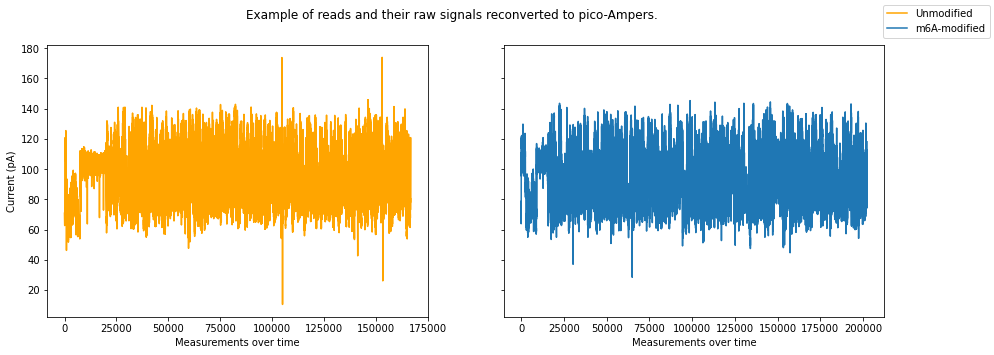

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
axes[0].plot( raw_to_pA( get_fast5_file(df_unmod_subset.iloc[np.random.randint(0, subset_size_unmod)].path) ), label="Unmodified", c="orange")
axes[1].plot( raw_to_pA( get_fast5_file(df_mod_subset.iloc[np.random.randint(0, subset_size_m6A)].path) ), label="m6A-modified" )
fig.legend()
fig.suptitle("Example of reads and their raw signals reconverted to pico-Ampers.")
axes[0].set_ylabel("Current (pA)")
axes[0].set_xlabel("Measurements over time")
axes[1].set_xlabel("Measurements over time")
plt.show()

## 3.0. Prepare training data

In [11]:
# split unmodified training data into X_train and X_test
X_train, X_test = train_test_split(df_unmod_subset, test_size=0.2)

In [12]:
X_train, X_val = train_test_split(X_train, test_size=0.5)

In [13]:
print("X_train shape (rows x cols):", X_train.shape[0], "x", X_train.shape[1])
print("X_val shape (rows x cols):", X_val.shape[0], "x", X_val.shape[1])
print("X_test shape (rows x cols):", X_test.shape[0], "x", X_test.shape[1])
print("Number of measurements in X_train: ", X_train.read_length.sum())
print("Number of measurements in X_val: ", X_val.read_length.sum())
print("Number of measurements in X_test: ", X_test.read_length.sum())

X_train shape (rows x cols): 40 x 17
X_val shape (rows x cols): 40 x 17
X_test shape (rows x cols): 20 x 17
Number of measurements in X_train:  6953565
Number of measurements in X_val:  6876370
Number of measurements in X_test:  3340034


In [14]:
print("Number of measurements in X_train: ", X_train.read_length.sum())

Number of measurements in X_train:  6953565


The next step is to retrieve the reconstructed signals from the disk and to build and to put them into an in-memory pandas DataFrame

In [24]:
X_train_signals = []
with tqdm(total=X_train.shape[0]) as pbar:
    for read in X_train.itertuples():
        # signal stored into fast5 are integers and have to be converted to pA 
        # (see the custom function "raw_to_pA" into the "ont_custom_functions.py" file)
        X_train_signals.append( raw_to_pA(get_fast5_file(read.path)) )
        pbar.update(1)
        
X_train_signals = pd.DataFrame(X_train_signals).T
X_train_signals # rows are timepoints of each read and columns are differents files/reads

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 77.12it/s]


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,93.897400,75.670258,70.008797,75.670258,65.866264,101.215874,70.423050,67.937531,75.946426,66.418602,...,127.728081,68.213699,66.418602,74.565582,79.122368,80.088959,148.026489,78.017693,64.071167,121.238113
1,74.841751,70.146881,62.690323,77.051102,62.828407,72.770485,76.498764,67.523277,74.289413,67.661362,...,65.175842,66.694771,62.137985,75.394089,78.431946,74.289413,78.570030,74.703667,66.970940,70.699219
2,72.908569,69.870712,64.209251,76.084511,61.861816,71.941978,72.080063,66.004349,76.222595,67.799446,...,63.380745,68.489868,62.690323,77.051102,77.879608,71.665810,80.779381,75.394089,64.347336,68.213699
3,75.117920,68.766037,63.104576,75.117920,64.347336,69.732628,75.532173,65.175842,78.708115,66.694771,...,61.861816,68.075615,62.966492,79.260452,77.879608,69.456459,80.779381,74.841751,65.037758,70.008797
4,75.256004,69.042206,63.104576,75.256004,65.866264,70.561134,72.494316,63.933083,72.080063,68.075615,...,64.623505,68.489868,64.623505,75.256004,74.565582,70.423050,77.741524,74.565582,64.347336,69.870712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.545517,NaN
224419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.402985,NaN
224420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.206978,NaN
224421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.425224,NaN


In [17]:
print("Memory used by DataFrame is about {} mb".format(round( X_train_signals.memory_usage().sum() / 1048576, 2 )) )

Memory used by DataFrame is about 18.82 mb


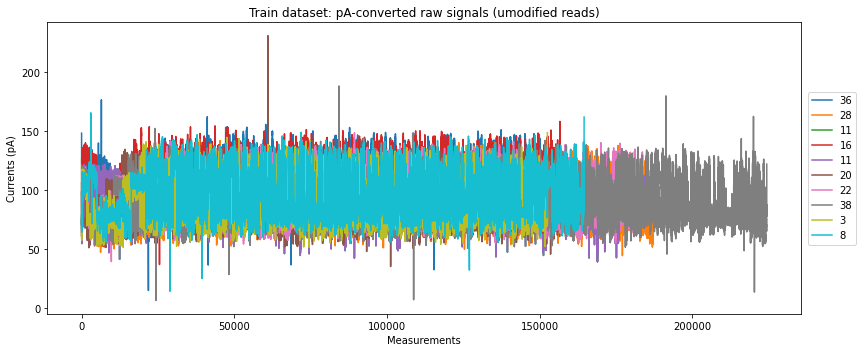

In [61]:
# visualize a random sample of the X_train generated signals
random_indices = np.random.choice(X_train_signals.columns, 10)
X_train_signals[random_indices].plot(figsize=(12,5))
plt.title("Train dataset: pA-converted raw signals (umodified reads)")
plt.ylabel("Currents (pA)")
plt.xlabel("Measurements")
plt.legend(bbox_to_anchor=(1.08, 0.5), loc="right")
plt.tight_layout()
plt.show()

## 3.0. Autoencoder's Neural Network Model

In [71]:
from keras.layers import Activation
model = Sequential()
model.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=(5, 10)))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 5, 20)             1680      
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 20)                2480      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 105       
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 4,265
Trainable params: 4,265
Non-trainable params: 0
_________________________________________________________________


In [113]:
TIME_STEPS = 10
n_features = 1

# useful functions
def create_sequences(values, time_steps=TIME_STEPS):
    import numpy
    '''
    Function to create a time_step version of the sequence.
    '''
    output=[]
    for i in range(len(values)+1 - time_steps):
        output.append(values[i:(i+time_steps)])
    return np.stack(output).reshape(len(output), time_steps, 1)


def recostruct_sequence(timestep_sequence):
    '''
    Function to reconstruct the sequence starting
    from the time_step version.
    '''
    output = []
    output += list(timestep_sequence[0].ravel())
    for i in timestep_sequence[1:]:
        output.append( i.ravel()[-1] )
    #output += list(timestep_sequence[-1].ravel())
    output = np.array(output)
    return output


def get_mae(signal, model):
    '''
    Function to get the reconstruction MAE error from a raw signal after the transformation in time_steps
    version and prediction of the reconstructed signal.
    '''
    X_scaled = StandardScaler().fit_transform(signal.dropna().values.reshape(-1,1))
    time_steps = create_sequences(X_scaled)
    time_step_pred = model.predict(time_steps)
    mae_loss = np.mean(np.abs(time_step_pred - time_steps.reshape(time_steps.shape[0], time_steps.shape[1], 1)), axis=1)
    return mae_loss

In [102]:
# define model
model = Sequential()
# Encoder
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(TIME_STEPS, n_features), merge_mode="ave"))
model.add(Bidirectional(LSTM(64, return_sequences=False), merge_mode="ave"))
model.add(RepeatVector(TIME_STEPS))
# Decoder
model.add(Bidirectional(LSTM(64, return_sequences=True), merge_mode="ave"))
model.add(Bidirectional(LSTM(32, return_sequences=True), merge_mode="ave"))
model.add(TimeDistributed(Dense(n_features)))
# optimizer and loss function
model.compile(optimizer='adam', loss='mse')
# print summary information
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_42 (Bidirectio (None, 10, 64)            33792     
_________________________________________________________________
bidirectional_43 (Bidirectio (None, 64)                66048     
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 10, 64)            0         
_________________________________________________________________
bidirectional_44 (Bidirectio (None, 10, 64)            66048     
_________________________________________________________________
bidirectional_45 (Bidirectio (None, 10, 32)            24832     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 1)             33        
Total params: 190,753
Trainable params: 190,753
Non-trainable params: 0
_______________________________________________

In [103]:
# a list with the history of each training for the current session and a list of the X_train sample already used
# for the network training. This could be a useful way to stop and continue the training.
histories = []
X_train_sample_used = []

In [6]:
# Prepare a directory to store all the checkpoints and history
checkpoint_dir = './ckpt'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# set version and date
version = "3_0_"
date = str(datetime.today()).replace("-", "_").replace(" ", "_").split(".")[0].replace(":", "_")

# define the checkpoint
filepath = os.path.join(checkpoint_dir, "model_v"+version+date+".h5")
filepath_history = os.path.join(checkpoint_dir, "model_v"+version+date+"_history.pickle")
filepath_X_train_sample_used = os.path.join(checkpoint_dir, "model_v"+version+date+"_Xtrain_used.pickle")
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [105]:
# fit the model using the input also as target since this will be a reconstruction model.
for i in X_train_signals.columns:
    # dropna() is for the presence of shorter sequences.
    # to avoid scale problems the signal of the reads have been standardized prior the training of the model.
    X_scaled = StandardScaler().fit_transform(X_train_signals[i].dropna().values.reshape(-1,1)) 
    X_train_time_steps = create_sequences(X_scaled) 
    print("#####################################################################################################")
    print(f"\nTraining on sample number {i+1} of {len(X_train_signals.columns)}", X_train_time_steps.shape, "\n")

    # fit the model with callbacks.
    history = model.fit(
        X_train_time_steps, X_train_time_steps,
        epochs=1,
        batch_size=2048,
        validation_split=0.1,
        shuffle=False,
        callbacks=callbacks_list
    )
    histories.append(history.history)
    X_train_sample_used.append(i)
    print("Saving losses histories as serialized object on disk.")
    with open(filepath_history, "wb") as output_file:
        pickle.dump(histories, output_file)
    print("Saving used training samples histories as serialized object on disk.")
    with open(filepath_X_train_sample_used, "wb") as output_file:
        pickle.dump(X_train_sample_used, output_file)

#####################################################################################################

Training on sample number 1 of 40 (152912, 10, 1) 

68/68 [==============================] - 61s 726ms/step - loss: 0.5365 - val_loss: 0.1482

Epoch 00001: loss improved from inf to 0.26492, saving model to ./ckpt\model_v3_0_2021_03_03_12_17_19.h5
Saving losses histories as serialized object on disk.
Saving used training samples histories as serialized object on disk.
#####################################################################################################

Training on sample number 2 of 40 (159523, 10, 1) 

71/71 [==============================] - 56s 783ms/step - loss: 0.0841 - val_loss: 0.0689

Epoch 00001: loss improved from 0.26492 to 0.08415, saving model to ./ckpt\model_v3_0_2021_03_03_12_17_19.h5
Saving losses histories as serialized object on disk.
Saving used training samples histories as serialized object on disk.
################################################

78/78 [==============================] - 66s 844ms/step - loss: 0.0339 - val_loss: 0.0329

Epoch 00001: loss improved from 0.03568 to 0.03389, saving model to ./ckpt\model_v3_0_2021_03_03_12_17_19.h5
Saving losses histories as serialized object on disk.
Saving used training samples histories as serialized object on disk.
#####################################################################################################

Training on sample number 39 of 40 (224414, 10, 1) 

99/99 [==============================] - 80s 813ms/step - loss: 0.0367 - val_loss: 0.0276

Epoch 00001: loss did not improve from 0.03389
Saving losses histories as serialized object on disk.
Saving used training samples histories as serialized object on disk.
#####################################################################################################

Training on sample number 40 of 40 (191135, 10, 1) 

84/84 [==============================] - 67s 793ms/step - loss: 0.0334 - val_loss: 0.0353

Epoch 00001: 

In [15]:
# load last best model
model = keras.models.load_model(filepath)

In [12]:
# to continue the training from the last X_train_sample_used, uncomment the following code and insert the right paths.
filepath = "./ckpt\\model_v3_0_2021_03_03_12_17_19.h5"
filepath_history = "./ckpt\\model_v3_0_2021_03_03_12_17_19_history.pickle"
filepath_X_train_sample_used = "./ckpt\\model_v3_0_2021_03_03_12_17_19_Xtrain_used.pickle"

# load last best model
model = keras.models.load_model(filepath)


# load losses and used training samples histories to continue training from
# the subsequent sample.
with open(filepath_history, "rb") as input_file:
    histories = pickle.load(input_file)
with open(filepath_X_train_sample_used, "rb") as input_file:
    X_train_sample_used = pickle.load(input_file)
'''
if X_train_sample_used != []:
    for i in X_train_signals.columns[X_train_signals.columns > np.max(X_train_sample_used)]:
        print("Restart training from the last X_train Sample used, that is sample with index:", np.max(X_train_sample_used))
        # dropna() is for the presence of shorter sequences.
        # to avoid scale problems the signal of the reads have been standardized prior the training of the model.
        X_scaled = StandardScaler().fit_transform(X_train_signals[i].dropna().values.reshape(-1,1)) 
        X_train_time_steps = create_sequences(X_scaled) 
        print("#####################################################################################################")
        print(f"\nTraining on sample number {i+1} of {len(X_train_signals.columns)}", X_train_time_steps.shape, "\n")

        # fit the model with callbacks.
        history = model.fit(
            X_train_time_steps, X_train_time_steps,
            epochs=3,
            batch_size=30,
            validation_split=0.1,
            shuffle=False,
            callbacks=callbacks_list
        )
        
        histories.append(history.history)
        X_train_sample_used.append(i)
        print("Saving losses histories as serialized object on disk.")
        with open(filepath_history, "wb") as output_file:
            pickle.dump(histories, output_file)
        print("Saving used training samples histories as serialized object on disk.")
        with open(filepath_X_train_sample_used, "wb") as output_file:
            pickle.dump(X_train_sample_used, output_file)
'''

'\nif X_train_sample_used != []:\n    for i in X_train_signals.columns[X_train_signals.columns > np.max(X_train_sample_used)]:\n        print("Restart training from the last X_train Sample used, that is sample with index:", np.max(X_train_sample_used))\n        # dropna() is for the presence of shorter sequences.\n        # to avoid scale problems the signal of the reads have been standardized prior the training of the model.\n        X_scaled = StandardScaler().fit_transform(X_train_signals[i].dropna().values.reshape(-1,1)) \n        X_train_time_steps = create_sequences(X_scaled) \n        print("#####################################################################################################")\n        print(f"\nTraining on sample number {i+1} of {len(X_train_signals.columns)}", X_train_time_steps.shape, "\n")\n\n        # fit the model with callbacks.\n        history = model.fit(\n            X_train_time_steps, X_train_time_steps,\n            epochs=3,\n            batch_siz

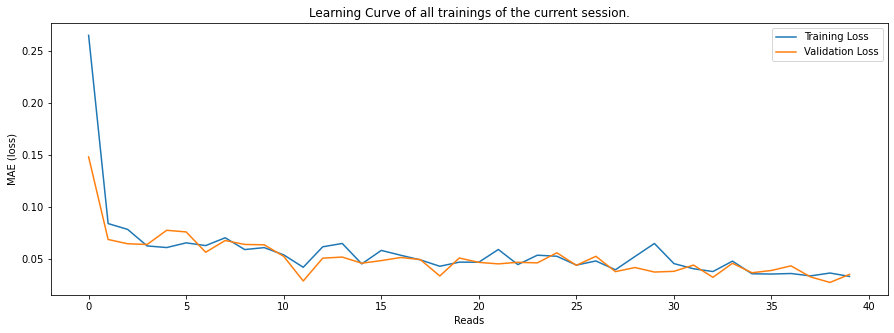

In [14]:
# plot the training and validation losses of all trainings in this session.
losses = []
val_losses = []

for training in histories:
    losses += training["loss"]
    val_losses += training["val_loss"]

# plotting
plt.figure(figsize=(15,5))
plt.plot(losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Learning Curve of all trainings of the current session.")
plt.xlabel("Reads")
plt.ylabel("MAE (loss)")
plt.legend()
plt.show()

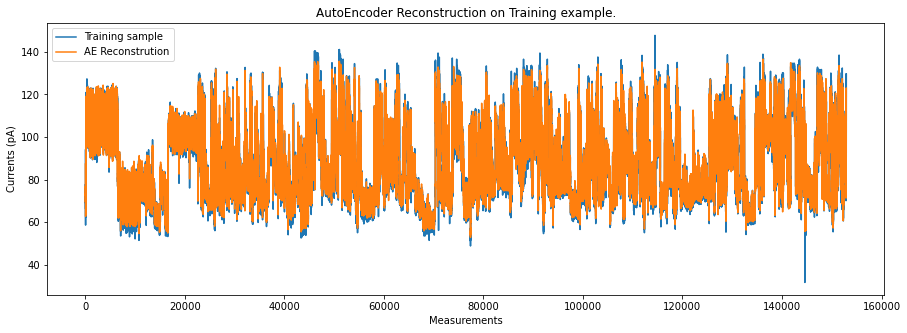

In [111]:
# Visualize reconstructed signal of on a training sample 
sc = StandardScaler()
train_sample = X_train_signals[0].dropna().values.reshape(-1,1)
train_sample_sc = sc.fit_transform(train_sample)
train_sample_time_step = create_sequences(train_sample_sc)
train_sample_pred = model.predict(create_sequences(train_sample_sc))
reconstructed_signal = recostruct_sequence(train_sample_pred)
reconstructed_signal = sc.inverse_transform(reconstructed_signal)

# plot results
plt.figure(figsize=(15,5))
plt.plot(train_sample, label="Training sample")
plt.plot(reconstructed_signal, label="AE Reconstrution")
plt.title("AutoEncoder Reconstruction on Training example.")
plt.xlabel("Measurements")
plt.ylabel("Currents (pA)")
plt.legend()
plt.show()

In [114]:
# Getting all the threshold computed for the training samples by the model
thresholds = []
mae_losses = []
with tqdm(total=len(X_train_signals.columns)) as pbar:
    for i in X_train_signals.columns:
        train_mae_loss = get_mae(X_train_signals[i], model)
        mae_losses.append(train_mae_loss)

        # Get reconstruction loss thresholds.
        threshold = np.max(train_mae_loss)
        thresholds.append(threshold)
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [19:17<00:00, 28.94s/it]


In [115]:
threshold_max = round(np.max(thresholds), 2)
print("Mean Threshold +/- S.D. on Training samples:", round(np.mean(thresholds), 2), "+/-", round(np.std(thresholds), 2), "S.D.")
print("Max Value for Threshold in training samples:", threshold_max)

Mean Threshold +/- S.D. on Training samples: 1.09 +/- 0.25 S.D.
Max Value for Threshold in training samples: 2.39


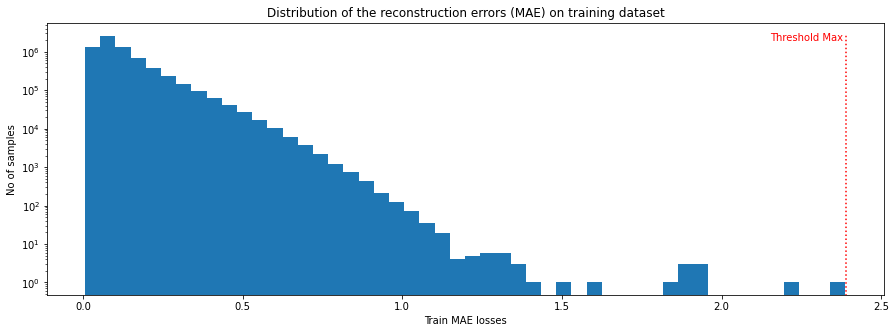

Reconstruction error threshold:  2.39


In [116]:
# plotting MAE reconstruction errors of the training dataset to visualize the maximum threshold.
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(mae_losses), bins=50)
plt.title("Distribution of the reconstruction errors (MAE) on training dataset")
plt.vlines(threshold_max, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.yscale(value="log")
plt.xlabel("Train MAE losses")
plt.ylabel("No of samples")
plt.text(threshold_max*0.9, plt.axis()[3]*0.35, "Threshold Max", c="r")
plt.show()

print("Reconstruction error threshold: ", threshold_max)

## 3.1. Evaluation of the model on X_val dataset.

Now I'd like to see if this threshold works well also on another unmodified read not yet used for the training of the model from the X_val dataframe. Thus we have to create a X_val_signal dataset with the raw signals converted to pA of the unmodified reads, in order to start the evaluations.

In [117]:
X_val_signals = []
with tqdm(total=X_val.shape[0]) as pbar:
    for read in X_val.itertuples():
        # signal stored into fast5 are integers and have to be converted to pA 
        # (see the custom function "raw_to_pA" into the "ont_custom_functions.py" file)
        X_val_signals.append( raw_to_pA(get_fast5_file(read.path)) )
        pbar.update(1)
X_val_signals = pd.DataFrame(X_val_signals).T
X_val_signals # rows are timepoints of each read and columns are differents files/reads

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.22it/s]


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,138.084412,64.761589,58.685875,70.699219,84.369576,109.639023,75.808342,95.002075,75.394089,70.699219,...,95.968666,77.465355,67.661362,61.999901,69.594543,75.670258,74.979836,71.803894,107.429672,97.763763
1,66.970940,62.690323,61.861816,65.866264,72.218147,76.084511,78.017693,64.623505,75.394089,69.180290,...,95.416328,66.970940,70.975388,67.385193,68.213699,77.051102,61.861816,71.251556,106.186913,67.523277
2,67.109024,62.828407,57.995453,71.941978,68.489868,75.117920,75.670258,62.828407,75.946426,68.904121,...,94.725906,69.318375,69.180290,67.109024,69.732628,76.084511,65.728180,69.732628,103.010971,67.385193
3,69.318375,62.966492,57.166946,68.489868,70.146881,75.117920,76.913017,72.494316,72.632401,66.556686,...,92.240387,67.799446,72.080063,67.937531,69.732628,75.117920,67.523277,70.975388,101.768211,67.661362
4,70.284966,62.137985,62.414154,69.456459,68.213699,76.360680,76.498764,63.794998,74.151329,69.180290,...,93.206978,66.418602,70.561134,66.280518,67.661362,75.256004,65.313927,69.870712,99.144608,69.180290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


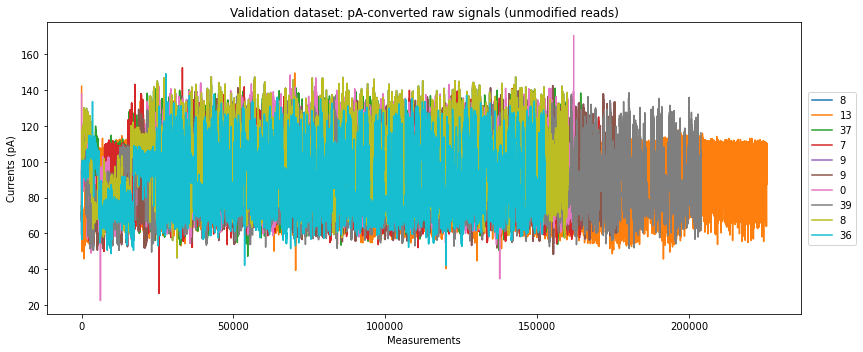

In [118]:
random_indices = np.random.choice(X_val_signals.columns, 10)
X_val_signals[random_indices].plot(figsize=(12,5))
plt.title("Validation dataset: pA-converted raw signals (unmodified reads)")
plt.ylabel("Currents (pA)")
plt.xlabel("Measurements")
plt.legend(bbox_to_anchor=(1.08, 0.5), loc="right")
plt.tight_layout()
plt.show()

In [119]:
# Getting all the MAE reconstruction errors computed for the validation samples by the model
from tqdm import tqdm

val_mae_losses = [] # where are stored the mae losses of validation samples.
val_sum_anomalies = [] # where are stored the cumulative number of anomalies per sample.
val_anomaly_indices = [] # where are stored the indices of the anomalies with respect the time_step version of the samples
with tqdm(total=len(X_val_signals.columns)) as pbar:
    for i in X_val_signals.columns:
        val_mae_loss = get_mae(X_val_signals[i], model)
        val_mae_losses.append(val_mae_loss)
        anomalies = val_mae_loss > threshold_max
        sum_anomalies = np.sum(anomalies)
        anomalies_indices = np.where(anomalies)
        val_sum_anomalies.append(sum_anomalies)
        val_anomaly_indices.append(anomalies_indices)

        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [24:29<00:00, 36.74s/it]


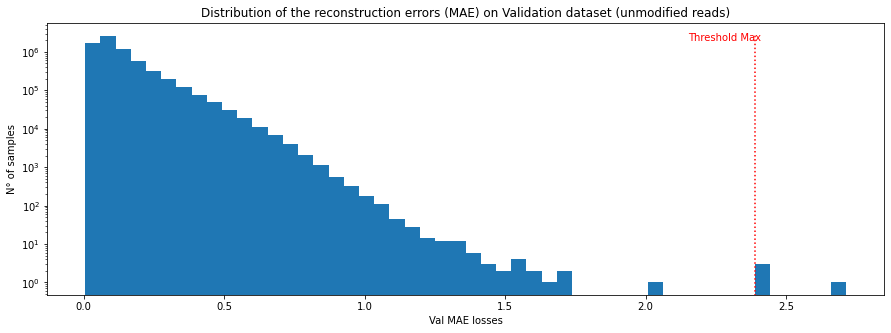

Number of anomaly samples in validation reads: 4


In [120]:
# plotting MAE reconstruction errors of the validation dataset.
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(val_mae_losses), bins=50)
plt.title("Distribution of the reconstruction errors (MAE) on Validation dataset (unmodified reads)")
plt.vlines(threshold_max, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.yscale(value="log")
plt.xlabel("Val MAE losses")
plt.ylabel("N° of samples")
plt.text(threshold_max*0.9, plt.axis()[3]*0.35, "Threshold Max", c="r")
plt.show()

print("Number of anomaly samples in validation reads:", np.sum(val_sum_anomalies))

Perfect! No anomalities have been found in the umodified validation dataset of reads. The model, even if trained on few reads seems to be able to discriminate using this threshold computed from training dataset. <br> <br>
<br>
## 3.2. Evaluation of the model on m6A modified dataset
First of all we need to split m6A subset data into training and test sets. Then I'm going to retrieve the pA-reconstructed raw signals for the m6A reads from the corresponding fast5 file. 

In [121]:
m6A_train, m6A_test = train_test_split(df_mod_subset, test_size=0.33)
print("m6A_train shape:", m6A_train.shape)
print("m6A_test shape:", m6A_test.shape)

m6A_train shape: (40, 17)
m6A_test shape: (20, 17)


In [122]:
m6A_train_signals = []
with tqdm(total=m6A_train.shape[0]) as pbar:
    for read in m6A_train.itertuples():
        # signal stored into fast5 are integers and have to be converted to pA 
        # (see the custom function "raw_to_pA" into the "ont_custom_functions.py" file)
        m6A_train_signals.append( raw_to_pA(get_fast5_file(read.path)) )
        pbar.update(1)

m6A_train_signals = pd.DataFrame(m6A_train_signals).T
m6A_train_signals # rows are timepoints of each read and columns are differents files/reads

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.41it/s]


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,77.519030,145.952654,151.814206,75.320948,131.152234,137.746480,83.234043,73.269404,77.372491,99.060235,...,94.810609,125.144143,74.441715,119.722207,131.445312,72.243633,139.504946,88.216363,80.889423,146.099193
1,75.027870,76.493258,74.441715,75.614025,79.424034,72.683249,79.863651,73.562482,75.760564,70.778245,...,101.991011,87.190591,73.415943,75.467487,77.079414,77.665569,68.873240,77.519030,76.786336,73.415943
2,69.752473,75.614025,75.027870,77.665569,77.958646,68.140546,79.424034,75.907103,75.760564,70.924784,...,101.258317,80.010190,71.657478,75.760564,77.225952,82.647888,66.968236,77.519030,78.251724,74.588254
3,72.243633,74.295176,74.441715,77.372491,80.449806,67.700930,77.958646,73.709021,75.614025,71.510939,...,103.016783,77.372491,69.899012,74.881331,79.130957,77.812108,67.994007,77.225952,79.130957,76.493258
4,73.855560,72.829788,75.614025,76.053642,78.251724,68.287085,75.614025,76.200181,79.277496,77.812108,...,104.189093,76.346719,70.485167,68.140546,76.346719,82.794427,68.433624,82.354811,77.079414,78.251724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
289432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
289433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
289434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


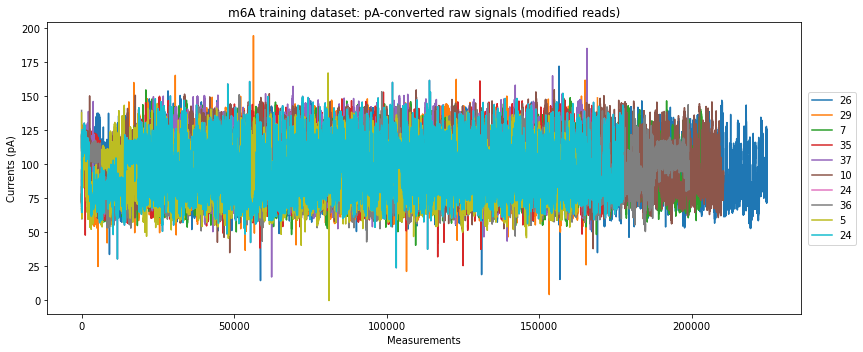

In [123]:
random_indices = np.random.choice(m6A_train_signals.columns, 10)
m6A_train_signals[random_indices].plot(figsize=(12,5))
plt.title("m6A training dataset: pA-converted raw signals (modified reads)")
plt.ylabel("Currents (pA)")
plt.xlabel("Measurements")
plt.legend(bbox_to_anchor=(1.08, 0.5), loc="right")
plt.tight_layout()
plt.show()

In [124]:
# Getting all the MAE reconstruction errors computed for the m6A training samples by the model
from tqdm import tqdm

m6A_train_mae_losses = [] # where are stored the mae losses of m6A training samples.
m6A_train_sum_anomalies = [] # where are stored the cumulative number of anomalies per sample.
m6A_train_anomaly_indices = [] # where are stored the indices of the anomalies with respect the time_step version of the samples
with tqdm(total=len(m6A_train_signals.columns)) as pbar:
    for i in m6A_train_signals.columns:
        m6A_train_mae_loss = get_mae(m6A_train_signals[i], model)
        m6A_train_mae_losses.append(m6A_train_mae_loss)
        anomalies = m6A_train_mae_loss > threshold_max
        sum_anomalies = np.sum(anomalies)
        anomalies_indices = np.where(anomalies)
        m6A_train_sum_anomalies.append(sum_anomalies)
        m6A_train_anomaly_indices.append(anomalies_indices)

        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [27:19<00:00, 41.00s/it]


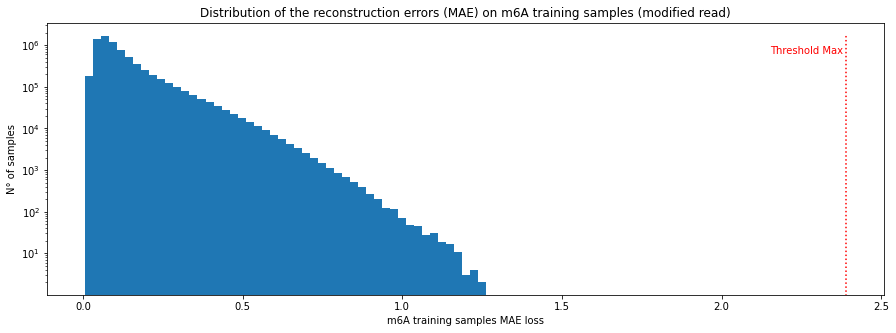

Number of anomaly samples: 0


In [125]:
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(m6A_train_mae_losses), bins=50)
plt.title("Distribution of the reconstruction errors (MAE) on m6A training samples (modified read)")
plt.vlines(threshold_max, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.text(threshold_max*0.9, plt.axis()[3]*0.35, "Threshold Max", c="r")
plt.yscale(value="log")
plt.xlabel("m6A training samples MAE loss")
plt.ylabel("N° of samples")
plt.show()

anomalies_m6A_train = np.concatenate(m6A_train_mae_losses) > threshold_max
print("Number of anomaly samples:", np.sum(anomalies_m6A_train))

## 3.3. Best Threshold choise.

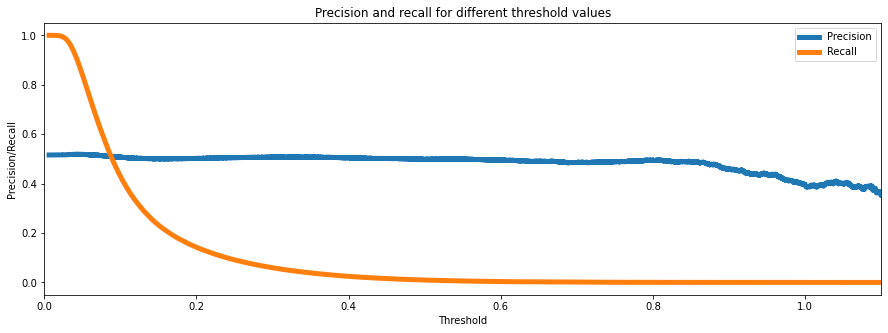

In [126]:
y_m6A_train = np.array([1 for i in np.concatenate(m6A_train_mae_losses)]) # real class vector for m6A_train
y_unmod_val = np.array([0 for i in np.concatenate(val_mae_losses)]) # real class vector for X_val unmodifed reads
# concatenate both of them into single vector
mse_total_val = np.concatenate([np.concatenate(m6A_train_mae_losses), np.concatenate(val_mae_losses)]) 
# concatenate also class labels into a single vector
y_total_val = np.concatenate([y_m6A_train, y_unmod_val]) 

# calculating precision/reacall scores over the threshold values
precision_rt, recall_rt, threshold_rt = precision_recall_curve(y_total_val, mse_total_val)

# producing precision/recall vs threshold curves
plt.figure(figsize=(15,5))
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.xlim(0, 1.1)
plt.legend()
plt.show()

Obviously, since the classes have been assigned in a not-common manner, with m6A modified reads containing also normal events and bases, the Precision/Recall vs threshold curves are not easily interpretable. Anyway they give some information about the behaviour of the model. It's better to use these information together with another way to see the problem that is the number of anomalies found in unmodified and m6A-modified reads by the variation of the threshold value on the validations sets as following:

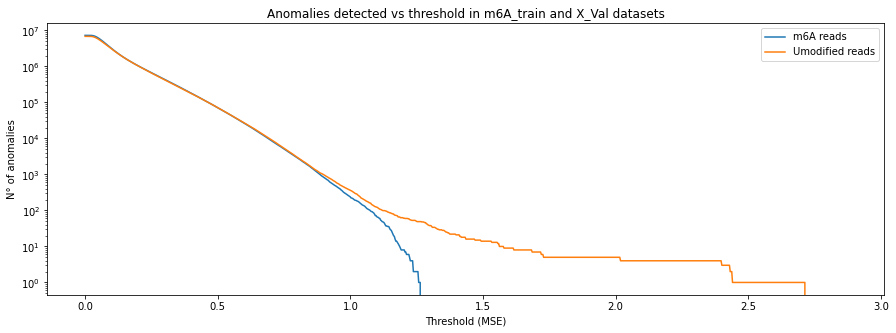

In [127]:
# evaluate how the number of detected anomalies changes in both 
# m6A_train and unmodified X_val samples in function of the threshold value.
trs = []
m6A_over_t = []
unmod_over_t =[]
for t in np.linspace(0, threshold_max*1.20, 1000):
    trs.append(t)
    m6A_over_t.append(np.sum(np.concatenate(m6A_train_mae_losses) > t))
    unmod_over_t.append(np.sum(np.concatenate(val_mae_losses) > t))

plt.figure(figsize=(15,5))
plt.plot(trs, m6A_over_t, label="m6A reads")
plt.plot(trs, unmod_over_t, label="Umodified reads")
plt.xlabel("Threshold (MSE)")
plt.ylabel("N° of anomalies")
plt.yscale("log")
plt.title("Anomalies detected vs threshold in m6A_train and X_Val datasets")
plt.legend()
plt.show()

In [128]:
# Detecting a good threshold as the minimum threshold value with 0 anomalies in unmodified reads
min_value_umod_anom = np.min(np.array(unmod_over_t))
min_index_unmod = np.min(np.argwhere(np.array(unmod_over_t) == min_value_umod_anom)) # first index where no anomalies are detected in unmodified data
new_threshold = trs[min_index_unmod] # threshold with 0 anomalies in unmodified reads
print("Best Threshold is:", new_threshold)

Best Threshold is: 2.7158438438438437


A good threshold seems to be: 2.7158438438438437 MAE

Number of anomalies in m6A_train samples: 0
Percentage of anomalies in modified m6A_train dataset on total measurements evaluated: 0.0 %

Number of anomalies in X_val samples: 0
Percentage of anomalies in unmodified X_val dataset on total measurements evaluated: 0.0 %

m6A_train/X_val anomalies ratio nan


<ipython-input-129-b4900e5879e4>:9: RuntimeWarning: invalid value encountered in long_scalars
  np.sum(np.concatenate(m6A_train_mae_losses) > new_threshold) /
C:\Users\adria\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


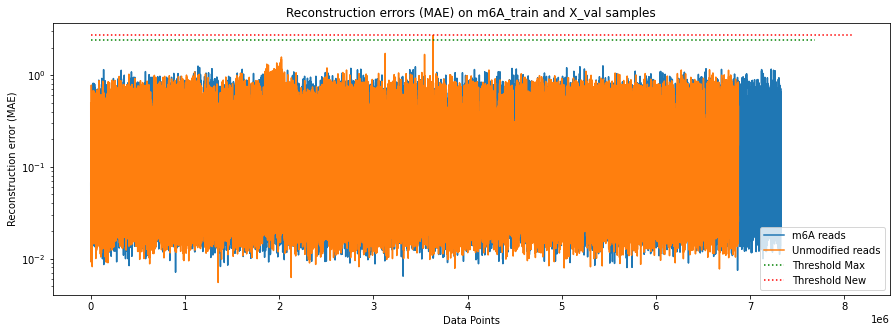

In [129]:
# Visualize results on Validation sets with the new best threshold and the old one computed on the training dataset.
print(f"A good threshold seems to be: {new_threshold} MAE\n")
# Results on m6A_train and X_val datasets:
print("Number of anomalies in m6A_train samples:", np.sum(np.concatenate(m6A_train_mae_losses) > new_threshold))
print("Percentage of anomalies in modified m6A_train dataset on total measurements evaluated:", round(np.sum(np.concatenate(m6A_train_mae_losses) > new_threshold) / np.concatenate(m6A_train_mae_losses).shape[0] * 100, 5), "%\n" )
print("Number of anomalies in X_val samples:", np.sum(np.concatenate(val_mae_losses) > new_threshold))
print("Percentage of anomalies in unmodified X_val dataset on total measurements evaluated:", round(np.sum(np.concatenate(val_mae_losses) > new_threshold) / np.concatenate(val_mae_losses).shape[0] * 100, 5), "%\n" )
print("m6A_train/X_val anomalies ratio", 
        np.sum(np.concatenate(m6A_train_mae_losses) > new_threshold) / 
        np.sum(np.concatenate(val_mae_losses) > new_threshold))

# Compare the Reconstruction MAE of the model in both the datasets with respect the max_threshold value
# computed in the training dataset.
plt.figure(figsize=(15,5))
plt.title("Reconstruction errors (MAE) on m6A_train and X_val samples")
plt.plot(np.concatenate(m6A_train_mae_losses), label="m6A reads", zorder=0)
plt.plot(np.concatenate(val_mae_losses), label="Unmodified reads", zorder=1)
plt.yscale(value="log")
plt.xlabel("Data Points")
plt.ylabel("Reconstruction error (MAE)")
plt.hlines(threshold_max, -1, plt.axis()[1], colors="g", linestyles="dotted", label="Threshold Max", zorder=3)
plt.hlines(new_threshold, -1, plt.axis()[1], colors="r", linestyles="dotted", label="Threshold New", zorder=4)
plt.legend()
plt.show()

Even if the results are not so efficient we detected some anomalies in m6A samples with respect unmodified samples that are not been used for the training of the model. Now evaluate these on m6A_test and X_test datasets with the new threshold (lower than the one computed on the training set) that maximized the precision. Recall values should be evaluated **carefully** since we don't know at the moment, if these fall on "A" base and can be considered really as m6A modified events. We only know for now, that the model is able with the "new threshold" to find some anomalies in m6A samples on no one can be detected in unmodified control samples.

## 4.0. Evaluation on test sets

In [130]:
X_test_signals = []
with tqdm(total=m6A_test.shape[0]) as pbar:
    for read in X_test.itertuples():
        # signal stored into fast5 are integers and have to be converted to pA 
        # (see the custom function "raw_to_pA" into the "ont_custom_functions.py" file)
        X_test_signals.append( raw_to_pA(get_fast5_file(read.path)) )
        pbar.update(1)
X_test_signals = pd.DataFrame(X_test_signals).T
X_test_signals # rows are timepoints of each read and columns are differents files/reads

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 71.78it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,130.075516,69.180290,66.418602,71.665810,99.558861,125.380646,75.946426,82.298309,75.670258,142.917366,113.643471,66.280518,75.394089,123.723633,111.572205,97.763763,68.351784,77.465355,67.385193,64.899673
1,68.351784,70.561134,65.313927,66.832855,69.318375,66.832855,74.979836,68.766037,77.051102,69.732628,110.605614,63.380745,65.866264,67.385193,70.837303,67.523277,65.728180,74.013245,72.218147,66.142433
2,65.728180,70.146881,65.728180,66.694771,69.456459,68.766037,76.084511,67.523277,76.084511,70.146881,112.676880,66.142433,64.899673,67.247108,70.146881,67.385193,66.970940,73.598991,70.284966,67.523277
3,66.418602,70.975388,65.728180,65.590096,67.799446,70.561134,77.465355,69.318375,75.117920,70.284966,117.095581,65.452011,64.761589,66.556686,69.870712,67.661362,69.594543,74.013245,70.423050,64.761589
4,68.904121,69.042206,66.418602,65.452011,68.766037,72.356232,73.875160,67.523277,75.256004,74.427498,116.128990,64.899673,61.447563,65.175842,71.251556,69.180290,68.351784,73.598991,69.870712,65.728180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.262627,NaN,NaN,NaN,NaN
203851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.282692,NaN,NaN,NaN,NaN
203852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.525452,NaN,NaN,NaN,NaN
203853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.391815,NaN,NaN,NaN,NaN


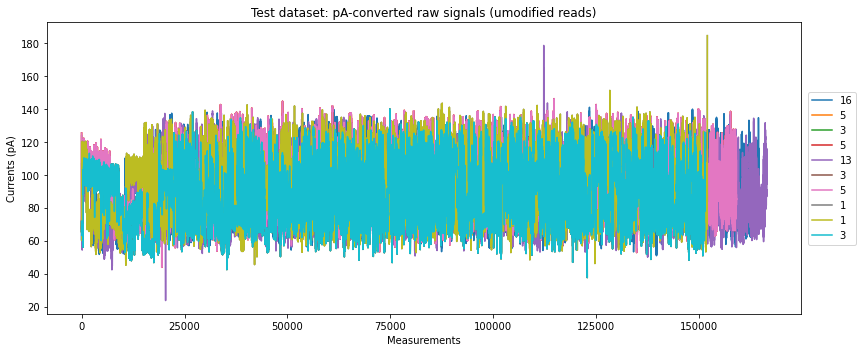

In [131]:
random_indices = np.random.choice(X_test_signals.columns, 10)
X_test_signals[random_indices].plot(figsize=(12,5))
plt.title("Test dataset: pA-converted raw signals (umodified reads)")
plt.ylabel("Currents (pA)")
plt.xlabel("Measurements")
plt.legend(bbox_to_anchor=(1.08, 0.5), loc="right")
plt.tight_layout()
plt.show()

In [132]:
# Getting all the MAE reconstruction errors computed for the test samples by the model
from tqdm import tqdm

test_mae_losses = [] # where are stored the mae losses of test samples.
test_sum_anomalies = [] # where are stored the cumulative number of anomalies per sample.
test_anomaly_indices = [] # where are stored the indices of the anomalies with respect the time_step version of the samples
with tqdm(total=len(X_test_signals.columns)) as pbar:
    for i in X_test_signals.columns:
        test_mae_loss = get_mae(X_test_signals[i], model)
        test_mae_losses.append(test_mae_loss)
        anomalies = test_mae_loss > new_threshold
        sum_anomalies = np.sum(anomalies)
        anomalies_indices = np.where(anomalies)
        test_sum_anomalies.append(sum_anomalies)
        test_anomaly_indices.append(anomalies_indices)

        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [15:09<00:00, 45.49s/it]


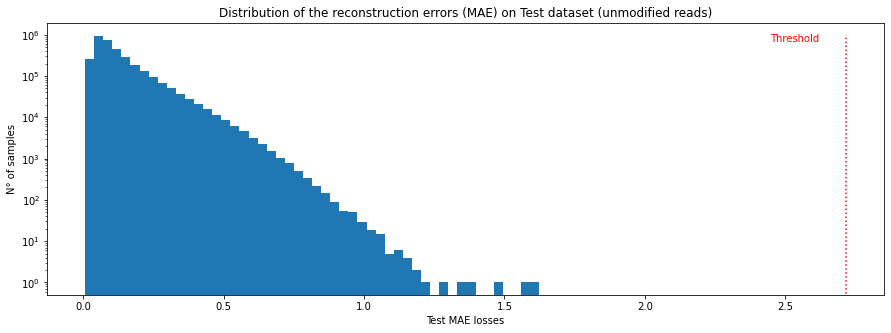

Number of anomaly samples in test reads: 0


In [133]:
# plotting MAE reconstruction errors of the test dataset.
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(test_mae_losses), bins=50)
plt.title("Distribution of the reconstruction errors (MAE) on Test dataset (unmodified reads)")
plt.vlines(new_threshold, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.yscale(value="log")
plt.xlabel("Test MAE losses")
plt.ylabel("N° of samples")
plt.text(new_threshold*0.9, plt.axis()[3]*0.35, "Threshold", c="r")
plt.show()
print("Number of anomaly samples in test reads:", np.sum(test_sum_anomalies))

In [134]:
m6A_test_signals = []
with tqdm(total=m6A_test.shape[0]) as pbar:
    for read in m6A_test.itertuples():
        # signal stored into fast5 are integers and have to be converted to pA 
        # (see the custom function "raw_to_pA" into the "ont_custom_functions.py" file)
        m6A_test_signals.append( raw_to_pA(get_fast5_file(read.path)) )
        pbar.update(1)
m6A_test_signals = pd.DataFrame(m6A_test_signals).T
m6A_test_signals # rows are timepoints of each read and columns are differents files/reads

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 75.03it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,78.691340,93.052144,151.228051,100.818701,98.767157,131.738389,90.414445,117.670664,141.263412,77.225952,94.957148,74.881331,79.130957,121.334134,79.424034,77.079414,86.311358,60.960145,103.602938,128.661074
1,77.665569,70.485167,83.380582,76.932875,70.631706,77.372491,77.958646,83.820199,74.441715,81.915194,87.776747,75.467487,76.639797,78.544802,75.907103,74.734793,88.362902,59.494756,80.156728,77.812108
2,72.829788,68.433624,78.251724,80.889423,72.536710,78.251724,77.812108,78.984418,72.243633,78.544802,87.190591,74.002099,75.320948,78.544802,77.225952,74.881331,83.527121,62.718610,80.449806,76.932875
3,72.390172,66.382080,79.863651,78.544802,72.536710,78.251724,76.053642,78.984418,71.071322,77.958646,86.311358,73.269404,74.588254,79.570573,78.398263,77.812108,84.845970,56.563980,77.665569,77.519030
4,75.320948,69.605934,79.863651,77.812108,74.441715,76.200181,76.639797,77.225952,65.502848,75.174409,86.750975,74.588254,77.372491,80.156728,75.174409,77.812108,82.354811,59.787834,76.932875,76.493258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241785,NaN,110.636801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241786,NaN,90.121367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241787,NaN,106.533714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241788,NaN,96.422536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


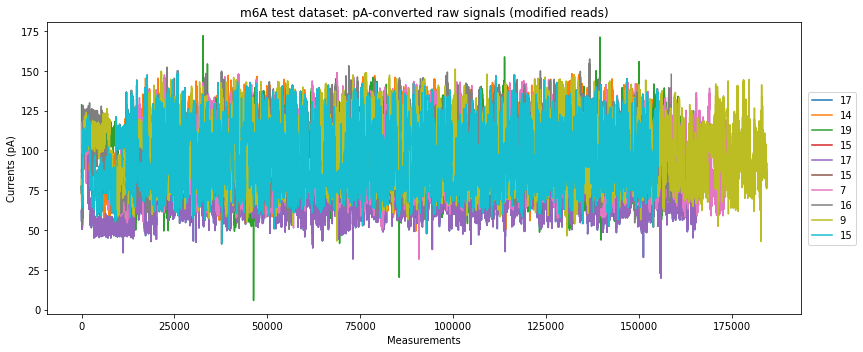

In [135]:
random_indices = np.random.choice(m6A_test_signals.columns, 10)
m6A_test_signals[random_indices].plot(figsize=(12,5))
plt.title("m6A test dataset: pA-converted raw signals (modified reads)")
plt.ylabel("Currents (pA)")
plt.xlabel("Measurements")
plt.legend(bbox_to_anchor=(1.08, 0.5), loc="right")
plt.tight_layout()
plt.show()

In [136]:
# Getting all the MAE reconstruction errors computed for the m6A test samples by the model
from tqdm import tqdm

m6A_test_mae_losses = [] # where are stored the mae losses of m6A test samples.
m6A_test_sum_anomalies = [] # where are stored the cumulative number of anomalies per sample.
m6A_test_anomaly_indices = [] # where are stored the indices of the anomalies with respect the time_step version of the samples
with tqdm(total=len(m6A_test_signals.columns)) as pbar:
    for i in m6A_test_signals.columns:
        m6A_test_mae_loss = get_mae(m6A_test_signals[i], model)
        m6A_test_mae_losses.append(m6A_test_mae_loss)
        anomalies = m6A_test_mae_loss > new_threshold
        sum_anomalies = np.sum(anomalies)
        anomalies_indices = np.where(anomalies)
        m6A_test_sum_anomalies.append(sum_anomalies)
        m6A_test_anomaly_indices.append(anomalies_indices)

        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [14:26<00:00, 43.32s/it]


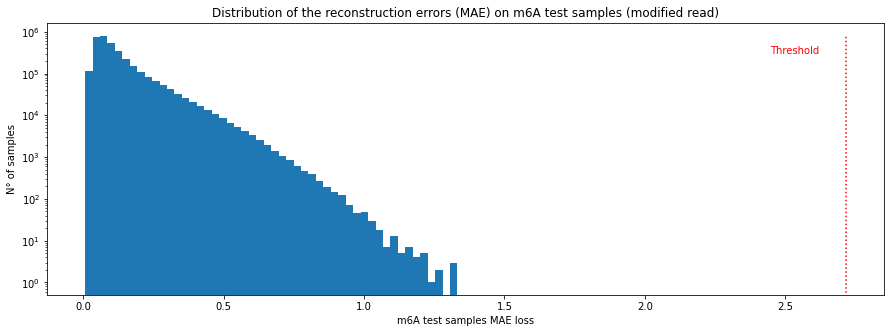

Number of anomaly samples in m6A test reads: 0


In [137]:
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(m6A_test_mae_losses), bins=50)
plt.title("Distribution of the reconstruction errors (MAE) on m6A test samples (modified read)")
plt.vlines(new_threshold, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.text(new_threshold*0.9, plt.axis()[3]*0.35, "Threshold", c="r")
plt.yscale(value="log")
plt.xlabel("m6A test samples MAE loss")
plt.ylabel("N° of samples")
plt.show()

anomalies_m6A_test = np.concatenate(m6A_test_mae_losses) > new_threshold
print("Number of anomaly samples in m6A test reads:", np.sum(m6A_test_sum_anomalies))

Number of anomalies in m6A_test samples: 0
Percentage of anomalies in m6A_test dataset on total measurements evaluated: 0.0 %

Number of anomalies in X_test samples: 0
Percentage of anomalies in unmodified X_test dataset on total measurements evaluated: 0.0 %

m6A_test/X_test anomalies ratio nan


<ipython-input-138-47c67531fa70>:7: RuntimeWarning: invalid value encountered in long_scalars
  np.sum(np.concatenate(m6A_test_mae_losses) > new_threshold) /
C:\Users\adria\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


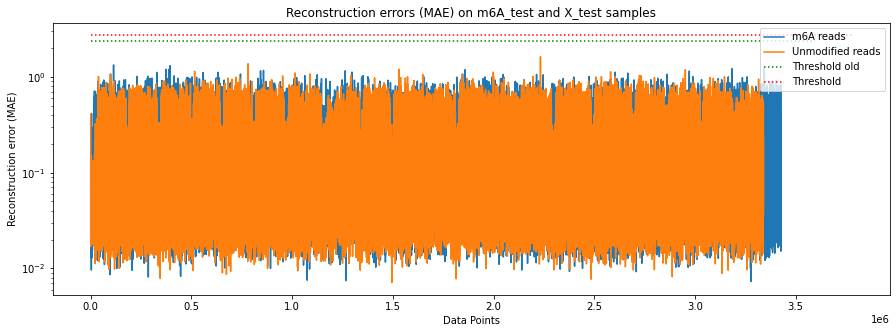

In [138]:
# Results on m6A_test and X_test datasets:
print("Number of anomalies in m6A_test samples:", np.sum(np.concatenate(m6A_test_mae_losses) > new_threshold))
print("Percentage of anomalies in m6A_test dataset on total measurements evaluated:", round(np.sum(np.concatenate(m6A_test_mae_losses) > new_threshold) / np.concatenate(m6A_test_mae_losses).shape[0] * 100, 5), "%\n" )
print("Number of anomalies in X_test samples:", np.sum(np.concatenate(test_mae_losses) > new_threshold))
print("Percentage of anomalies in unmodified X_test dataset on total measurements evaluated:", round(np.sum(np.concatenate(test_mae_losses) > new_threshold) / np.concatenate(test_mae_losses).shape[0] * 100, 5), "%\n" )
print("m6A_test/X_test anomalies ratio", 
        np.sum(np.concatenate(m6A_test_mae_losses) > new_threshold) / 
        np.sum(np.concatenate(test_mae_losses) > new_threshold))

# Compare the Reconstruction MAE of the model in both the datasets with respect the max_threshold value
# computed in the training dataset.
plt.figure(figsize=(15,5))
plt.title("Reconstruction errors (MAE) on m6A_test and X_test samples")
plt.plot(np.concatenate(m6A_test_mae_losses), label="m6A reads", zorder=0)
plt.plot(np.concatenate(test_mae_losses), label="Unmodified reads", zorder=1)
plt.yscale(value="log")
plt.xlabel("Data Points")
plt.ylabel("Reconstruction error (MAE)")
plt.hlines(threshold_max, -1, plt.axis()[1], colors="g", linestyles="dotted", label="Threshold old", zorder=3)
plt.hlines(new_threshold, -1, plt.axis()[1], colors="r", linestyles="dotted", label="Threshold", zorder=4)
plt.legend()
plt.show()